In [5]:

import importlib.resources
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from collections import Counter
import random


In [9]:
IMAGE_FOLDER_PATH = "../data/main"

In [11]:
# Character count
Counter(len(n.split("-")[0]) for n in os.listdir(IMAGE_FOLDER_PATH))

Counter({4: 2043, 6: 2022, 7: 2002, 8: 1993, 5: 1940, 9: 1})

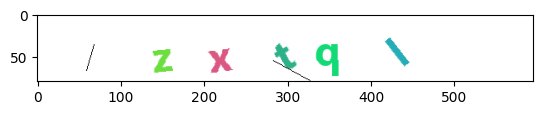

In [13]:
# Read the image
img = cv2.imread("../data/main/zxtql-0.png")
plt.imshow(img)




(80, 510, 3)


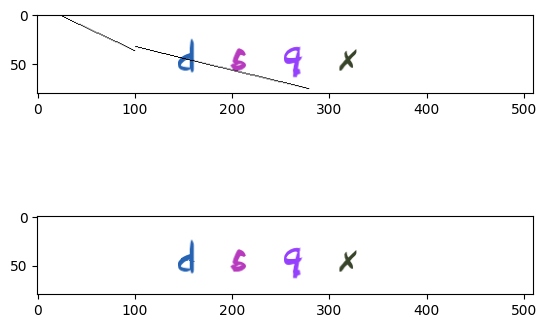

In [17]:
# Data cleaning: black line removal
colors = set()

def fetch_random_image():
    return random.choice(os.listdir(IMAGE_FOLDER_PATH))

def get_pixel(img, i, j):
    if i < 0 or j < 0 or i >= img.shape[0] or j >= img.shape[1]:
        return None
    return img[i][j]

def read_image(image_name):
    return cv2.imread(f"{IMAGE_FOLDER_PATH}/{image_name}")

def test_image(img):
    img = img.copy()
    max_colors = 10
    counter = Counter()
    for row in img:
        for pixel in row:
            counter[str(pixel)] += 1

    accepted_colours = [color for (color, _) in counter.most_common(max_colors + 2)]
    for i, row in enumerate(img):
        for j, pixel in enumerate(row):
            if str(pixel) == "[0 0 0]":
                # grab from surroundings:
                surrounding_pixels = [get_pixel(img, i + x, j + y) for x in range(-1, 2) for y in range(-1, 2) if x != 0 or y != 0 and str(pixel) in accepted_colours]
                fill = Counter(map(str, surrounding_pixels)).most_common(1)[0][0]
                fill_pixels = list(map(int, fill[1:-1].split()))
                # print(fill_pixels)
                for k in range(3):
                    img[i][j][k] = fill_pixels[k]

    return img

def test_image(img):
    img = img.copy()
    print(img.shape)

    # Flatten image for faster counting
    flat_pixels = img.reshape(-1, 3)

    # Count unique colors
    unique, counts = np.unique(flat_pixels, axis=0, return_counts=True)
    max_colors = 10

    # Get most common colors (excluding black [0, 0, 0])
    most_common_colors = unique[np.argsort(-counts)][:max_colors + 2]
    most_common_colors = [color for color in most_common_colors if not np.array_equal(color, [0, 0, 0])]

    # Identify black pixels
    black_mask = (img == [0, 0, 0]).all(axis=-1)

    # Process black pixels
    if np.any(black_mask):
        padded_img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_REFLECT)

        # Iterate over black pixels only
        black_indices = np.argwhere(black_mask)

        for x, y in black_indices:
            # Extract 3x3 neighborhood
            neighborhood = padded_img[x:x + 3, y:y + 3].reshape(-1, 3)

            # Filter neighborhood with most common colors
            valid_neighbors = [tuple(pixel) for pixel in neighborhood if tuple(pixel) in map(tuple, most_common_colors)]

            if valid_neighbors:
                # Find most common color in the neighborhood
                fill_pixel = Counter(valid_neighbors).most_common(1)[0][0]
                img[x, y] = fill_pixel


    return img

# test_image("zxtql-0.png")
random_image_name = fetch_random_image()
random_image = read_image(random_image_name)
plt.subplot(211); plt.imshow(random_image)
plt.subplot(212); plt.imshow(test_image(random_image))

(80, 615, 3)
c1dq8-0.png
(80, 615, 3)


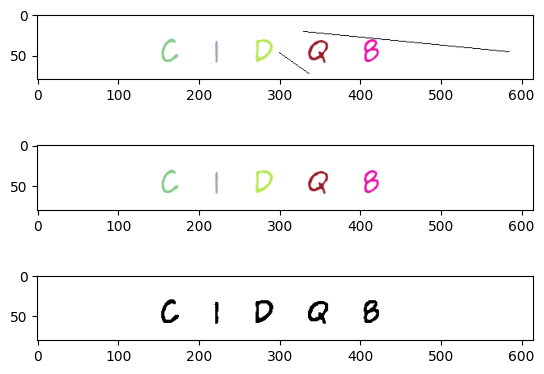

In [38]:
# Preprocessing: Color things black
def color_letters_black(img):
    img = img.copy()

    for i, row in enumerate(img):
        for j, pixel in enumerate(row):
            if not (pixel == [255, 255, 255]).all():
                img[i][j] = [0, 0, 0]
            else:
                img[i][j] = [255, 255, 255]

    return img

random_image_name = fetch_random_image()
random_image = read_image(random_image_name)
cleaned_lines = test_image(random_image)
black_letters = color_letters_black(cleaned_lines)

print(random_image_name)
plt.subplot(311); plt.imshow(random_image)
plt.subplot(312); plt.imshow(test_image(random_image))
plt.subplot(313); plt.imshow(black_letters)



0chnm34-0.png
(80, 245, 3)
(80, 245, 3)


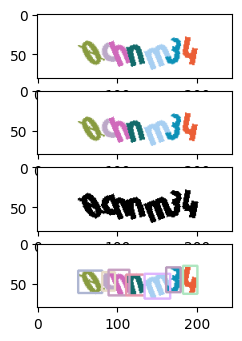

In [97]:

def merge_boxes(box1, box2):
    return [min(box1[0], box2[0]), max(box1[1], box2[1]), min(box1[2], box2[2]), max(box1[3], box2[3])]

def is_surrounded_horizontally(box1, box2)-> bool:
    """return box1 horizontally is inside box2"""
    return box1[2] >= box2[2] and box1[3] <= box2[3]

def is_tiny_box(box):
    return (abs(box[1] - box[0]) * abs(box[3] - box[2])) < 20

def generate_random_color():
    return [random.randint(150, 255) for _ in range(3)]

def partition_box(box, n=2):
    print(type(box[3]))
    print(box[3], box[2], n, (box[3] - box[2]) // n)
    part_length = int((box[3] - box[2]) // n)
    print(part_length)
    return [[box[0], box[1], box[2] + i * part_length, box[2] + (i + 1) * part_length] for i in range(n)]

def pixels_are_close(pixel1, pixel2, atol=25):
    return np.sum(np.abs(pixel1 - pixel2)) < atol

def get_bounding_boxes(img):
    # Assume this is the cleaned black letter image
    img = img.copy()

    shape = img.shape[:2]
    visited = np.zeros(shape, dtype=bool)
    bounding_boxes = [] # top bottom left right

    def dfs(i, j, color):
        if i < 0 or j < 0 or i >= shape[0] or j >= shape[1] or visited[i][j]:
            return
        if pixels_are_close(img[i][j], [255, 255, 255]):
            return
        # if color is not close enough return
        if not pixels_are_close(img[i][j], color):
            return  
        visited[i][j] = True
        bounding_boxes[-1][0] = min(bounding_boxes[-1][0], i)
        bounding_boxes[-1][1] = max(bounding_boxes[-1][1], i)
        bounding_boxes[-1][2] = min(bounding_boxes[-1][2], j)
        bounding_boxes[-1][3] = max(bounding_boxes[-1][3], j)
        dfs(i + 1, j, color)
        dfs(i - 1, j, color)
        dfs(i, j + 1, color)
        dfs(i, j - 1, color)

    for i in range(shape[0]):
        for j in range(shape[1]):
            if visited[i][j] or pixels_are_close(img[i][j], [255, 255, 255]):
                continue
            bounding_boxes.append([i, i, j, j])
            dfs(i, j, img[i][j])

    bounding_boxes = [box for box in bounding_boxes if box[0] != box[1] and box[2] != box[3]]
    
    # Merge boxes
    bounding_boxes.sort(key=lambda x: x[2])
    merged_boxes = []
    for box in bounding_boxes:
        if not merged_boxes:
            merged_boxes.append(box)
        else:
            if is_surrounded_horizontally(box, merged_boxes[-1]) or is_surrounded_horizontally(merged_boxes[-1], box):
                # print("surrounded", abs(box[1] - box[0]) * abs(box[3] - box[2]))
                merged_boxes[-1] = merge_boxes(merged_boxes[-1], box)
            elif (is_tiny_box(box) or is_tiny_box(merged_boxes[-1])) and box[2] - merged_boxes[-1][3] < 30:
                # print("tiny", abs(box[1] - box[0]) * abs(box[3] - box[2]))
                # merged_boxes[-1] = merge_boxes(merged_boxes[-1], box)
                # Note: we don't append tiny boxes for now, seem to be causing the effect
                pass
            else:
                # print("not tiny", abs(box[1] - box[0]) * abs(box[3] - box[2]))
                merged_boxes.append(box)

    # Split boxes
    horizontal_lengths = [abs(box[3] - box[2]) for box in merged_boxes]
    median_length = np.median(horizontal_lengths)
    # split_boxes = []
    # for box in merged_boxes:
    #     partition_count = max(int(box[3] - box[2]) // (median_length * 0.95), 1)
    #     for part in partition_box(box, int(partition_count)):
    #         split_boxes.append(part)
        # except Exception as e:
        #     print(e)
        #     print("Box", box)
        
    # print(split_boxes)

    # print("bounding box count", len(bounding_boxes))
    # for box in bounding_boxes:
    #     # print(box)
    #     cv2.rectangle(img, (box[2], box[0]), (box[3], box[1]), (255, 0, 0), 1)

    # for box in merged_boxes:
    #     # print(box)
    #     cv2.rectangle(img, (box[2], box[0]), (box[3], box[1]), (0, 0, 255), 1)
    
    # print(len(split_boxes))
    for box in merged_boxes:
        # print(box)
        cv2.rectangle(img, (box[2], box[0]), (box[3], box[1]), generate_random_color(), 2)

    return img, merged_boxes

random_image_name = "0chnm34-0.png" or fetch_random_image()
# random_image_name = fetch_random_image()
print(random_image_name)
random_image =   read_image(random_image_name)
cleaned_lines = test_image(random_image)
black_letters = color_letters_black(cleaned_lines)
boxes, _ = get_bounding_boxes(cleaned_lines)
# black_boxes, _ = get_bounding_boxes(black_letters)

plt.subplot(511); plt.imshow(random_image)
plt.subplot(512); plt.imshow(test_image(random_image))
plt.subplot(513); plt.imshow(black_letters)
plt.subplot(514); plt.imshow(boxes)
# plt.subplot(515); plt.imshow(black_boxes)
    

quxywuio-0.png
(80, 330, 3)
[[34, 64, 45, 84], [31, 63, 85, 116], [31, 60, 117, 149], [30, 62, 162, 187], [31, 61, 197, 236], [30, 61, 245, 273], [32, 60, 278, 308], [31, 62, 309, 329]]
bounding box count 86
8


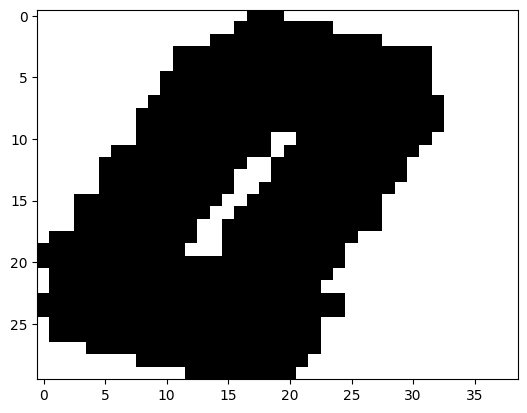

'isa'


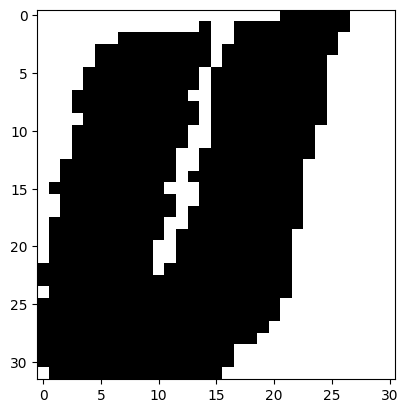

'ij'


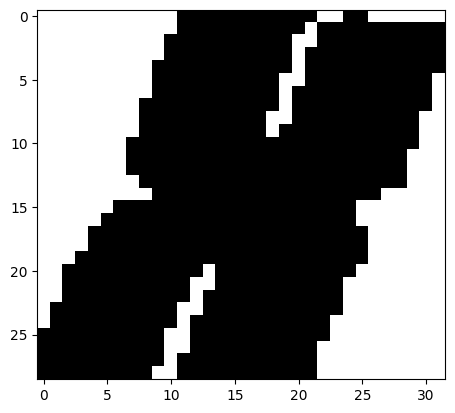

'a'


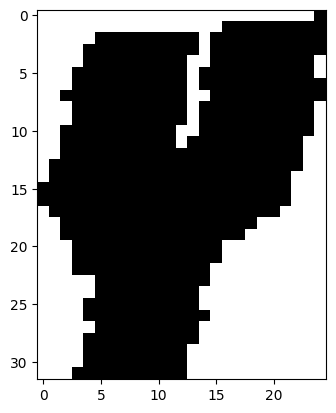

'd'


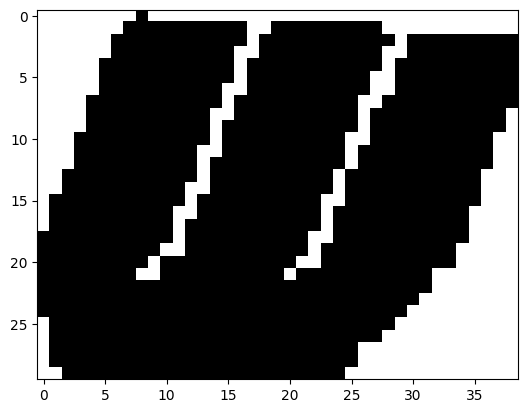

'7'


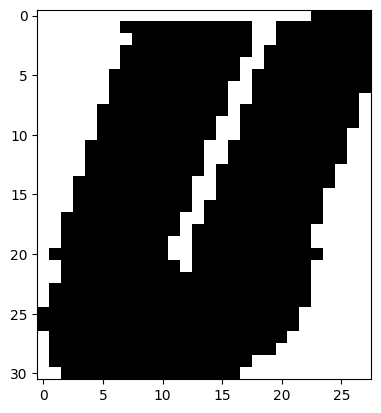

'ij'


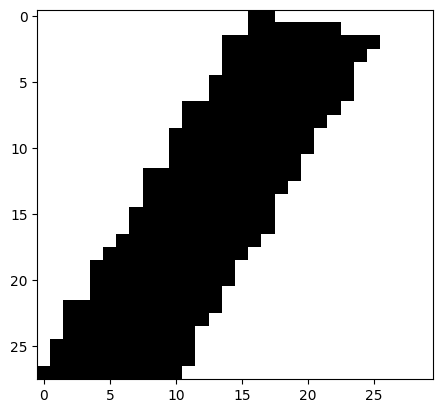

'yA'


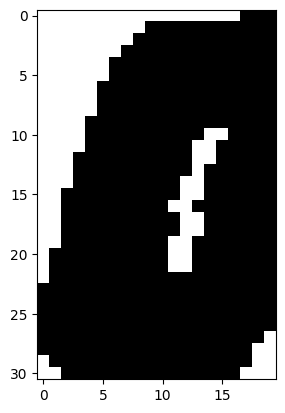

'fi'
8 isaijad7ijyAfi


In [ ]:
import pytesseract

random_image_name = fetch_random_image()
print(random_image_name)
cleaned = test_image(read_image(random_image_name))
boxes_drawn, boxes = get_bounding_boxes(cleaned)
# print(boxes)
cleaned = cv2.cvtColor(color_letters_black(cleaned), cv2.COLOR_BGR2RGB)
plt.imshow(boxes_drawn)
custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

result = ""
for box in boxes:
    x1, x2, y1, y2 = box
    cropped = cleaned[x1:x2, y1:y2]
    plt.imshow(cropped)
    plt.show()
    box_result = pytesseract.image_to_string(cropped, config=custom_config).strip()
    print(repr(box_result))
    result += box_result
print(len(boxes), result)

In [28]:
import easyocr
import difflib
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
random_image_name = fetch_random_image()
# print(random_image_name)
cleaned = test_image(read_image(random_image_name))
# plt.imshow(cleaned)
result = reader.readtext(cleaned)
# print(result)

count = 0
for image in os.listdir("main"):
    # print(image)
    if not image.endswith(".png"):
        continue
    cleaned = test_image(read_image(image))
    result = reader.readtext(cleaned)
    label = image.split("-")[0]
    # if label is very different from text, break and print
    # Extract text from result
    extracted_text = "".join([res[1] for res in result]).replace(" ", "").replace("\n", "")

    # Calculate similarity ratio
    similarity_ratio = difflib.SequenceMatcher(None, label, extracted_text).ratio()

    # If similarity is very low, print the details
    if similarity_ratio < 0.5:
        print(f"Label: {label}, Extracted Text: {extracted_text}, Similarity: {similarity_ratio}")
        count += 1

print(count)


KeyboardInterrupt: 